In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols 
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults 
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [16]:
dap = pd.concat(map(pd.read_csv, ['C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Day Ahead Power Price/Day-ahead Prices_201801010000-201901010000.csv',
                                 'C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Day Ahead Power Price/Day-ahead Prices_201901010000-202001010000.csv',
                                 'C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Day Ahead Power Price/Day-ahead Prices_202001010000-202101010000.csv']))

In [17]:
dap.head(10)

,MTU (CET),Day-ahead Price [EUR/MWh]
0,01.01.2018 00:00 - 01.01.2018 01:00,55.09
1,01.01.2018 01:00 - 01.01.2018 02:00,55.08
2,01.01.2018 02:00 - 01.01.2018 03:00,39.38
3,01.01.2018 03:00 - 01.01.2018 04:00,38.56
4,01.01.2018 04:00 - 01.01.2018 05:00,38.56
5,01.01.2018 05:00 - 01.01.2018 06:00,38.24
6,01.01.2018 06:00 - 01.01.2018 07:00,38.56
7,01.01.2018 07:00 - 01.01.2018 08:00,26.1
8,01.01.2018 08:00 - 01.01.2018 09:00,28.03
9,01.01.2018 09:00 - 01.01.2018 10:00,28.03


In [18]:
dap = dap.iloc[0:24218]

In [19]:
dap

,MTU (CET),Day-ahead Price [EUR/MWh]
0,01.01.2018 00:00 - 01.01.2018 01:00,55.09
1,01.01.2018 01:00 - 01.01.2018 02:00,55.08
2,01.01.2018 02:00 - 01.01.2018 03:00,39.38
3,01.01.2018 03:00 - 01.01.2018 04:00,38.56
4,01.01.2018 04:00 - 01.01.2018 05:00,38.56
...,...,...
6691,05.10.2020 19:00 - 05.10.2020 20:00,135.00
6692,05.10.2020 20:00 - 05.10.2020 21:00,115.00
6693,05.10.2020 21:00 - 05.10.2020 22:00,65.01
6694,05.10.2020 22:00 - 05.10.2020 23:00,43.93


In [22]:
dap[['Start_date','End_date']] = dap['MTU (CET)'].str.split("-",expand=True,)
dap_df = pd.DataFrame(data=dap)
dap_df
dap_df['Start_date'] = pd.to_datetime(dap_df['Start_date'], utc=True, infer_datetime_format=True,dayfirst= True)
dap_df = dap_df.set_index('Start_date')
dap_df.drop(columns='MTU (CET)', inplace=True)
dap_df.drop(columns='End_date', inplace=True)

In [23]:
dap_df.head()

,Day-ahead Price [EUR/MWh]
Start_date,
2018-01-01 00:00:00+00:00,55.09
2018-01-01 01:00:00+00:00,55.08
2018-01-01 02:00:00+00:00,39.38
2018-01-01 03:00:00+00:00,38.56
2018-01-01 04:00:00+00:00,38.56


In [24]:
dap_df.isnull().values.sum()

98

In [25]:
pd.DataFrame(dap_df['Day-ahead Price [EUR/MWh]'].loc['2018-01-01':'2020-9-30']).tail(25)

,Day-ahead Price [EUR/MWh]
Start_date,
2020-09-29 23:00:00+00:00,25.56
2020-09-30 00:00:00+00:00,-2.04
2020-09-30 01:00:00+00:00,-4.82
2020-09-30 02:00:00+00:00,-4.82
2020-09-30 03:00:00+00:00,-0.04
2020-09-30 04:00:00+00:00,24.98
2020-09-30 05:00:00+00:00,29.29
2020-09-30 06:00:00+00:00,36.22
2020-09-30 07:00:00+00:00,39.77


In [26]:
dap_df = dap_df.apply(pd.to_numeric, errors='coerce')

In [27]:
dap_df = dap_df.interpolate(method ='linear',limit_direction ='both', axis = 0)

In [28]:
dap_df.isna().values.sum()
dap_df.isnull().values.sum()

0

In [29]:
dap_df.dtypes

Day-ahead Price [EUR/MWh]    float64
dtype: object

In [30]:
dap_df_new = dap_df.resample('D').mean().round(2)
dap_df_new.head(10)

,Day-ahead Price [EUR/MWh]
Start_date,
2018-01-01 00:00:00+00:00,46.93
2018-01-02 00:00:00+00:00,53.53
2018-01-03 00:00:00+00:00,41.59
2018-01-04 00:00:00+00:00,59.25
2018-01-05 00:00:00+00:00,62.56
2018-01-06 00:00:00+00:00,52.74
2018-01-07 00:00:00+00:00,53.23
2018-01-08 00:00:00+00:00,52.50
2018-01-09 00:00:00+00:00,53.10


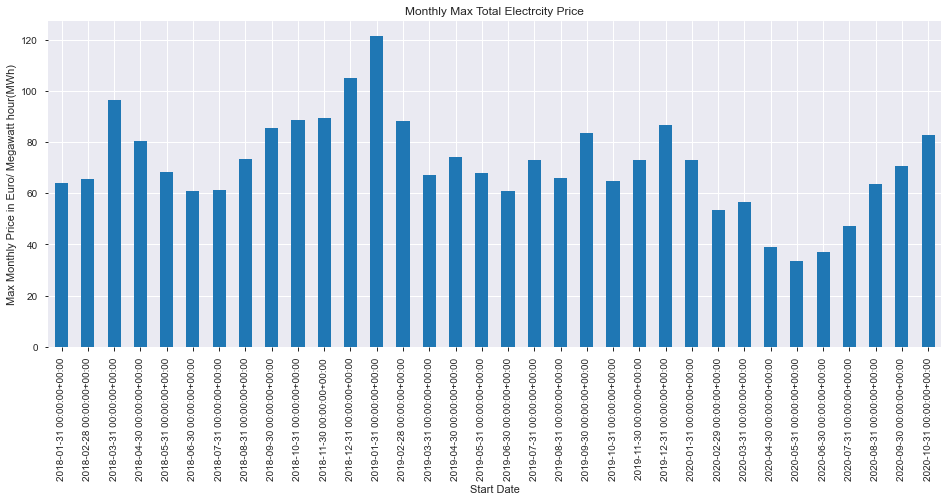

In [31]:
title = 'Monthly Max Total Electrcity Price'
dap_df_new['Day-ahead Price [EUR/MWh]'].resample('M').max().plot.bar(figsize=(16,6), title=title,color='#1f77b4',
                                                                     xlabel='Start Date', ylabel= 'Max Monthly Price in Euro/ Megawatt hour(MWh)');

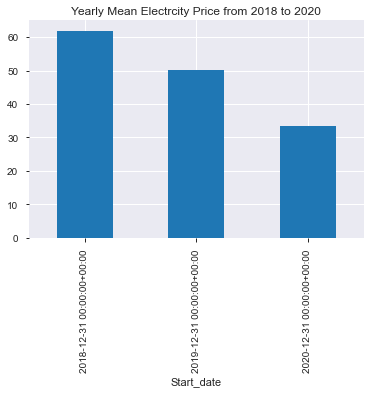

In [32]:
dap_df_new['Day-ahead Price [EUR/MWh]'].resample('A').mean().plot.bar(title='Yearly Mean Electrcity Price from 2018 to 2020');

In [33]:
dap_df_new.shape

(1009, 1)

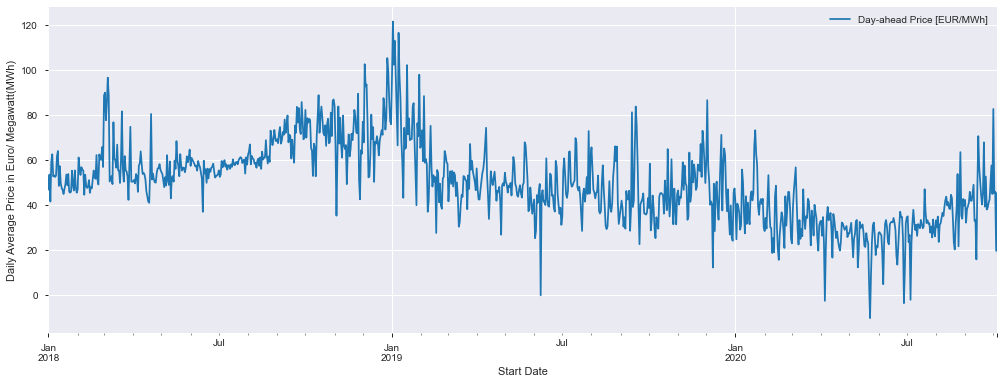

In [34]:
dap_df_new.plot(figsize=(17,6), xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)');

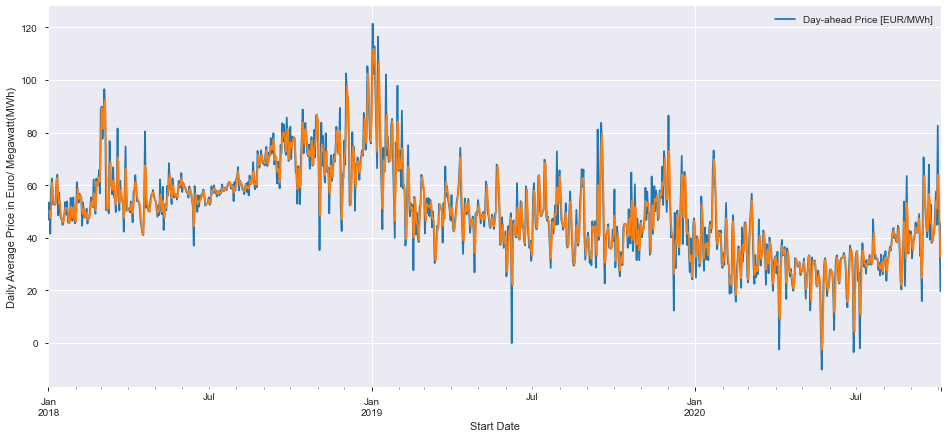

In [35]:
dap_df_new.plot(figsize=(16,7));
dap_df_new.rolling(window=2).mean()['Day-ahead Price [EUR/MWh]'].plot( xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)');

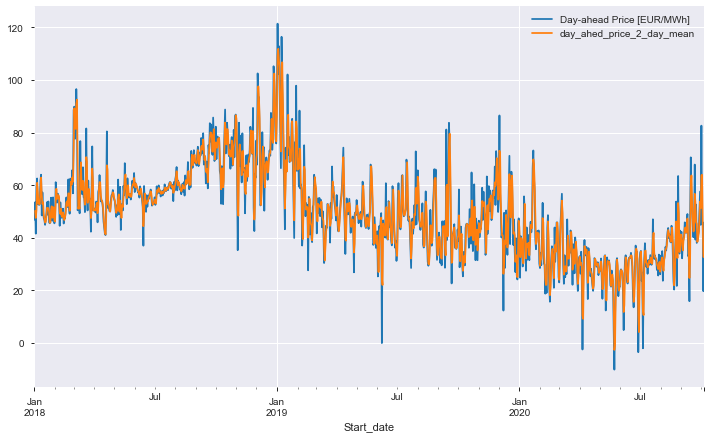

In [36]:
dap_df_new['day_ahed_price_2_day_mean'] = dap_df_new['Day-ahead Price [EUR/MWh]'].rolling(window=2).mean().round(2)
dap_df_new.plot(figsize=(12,7));

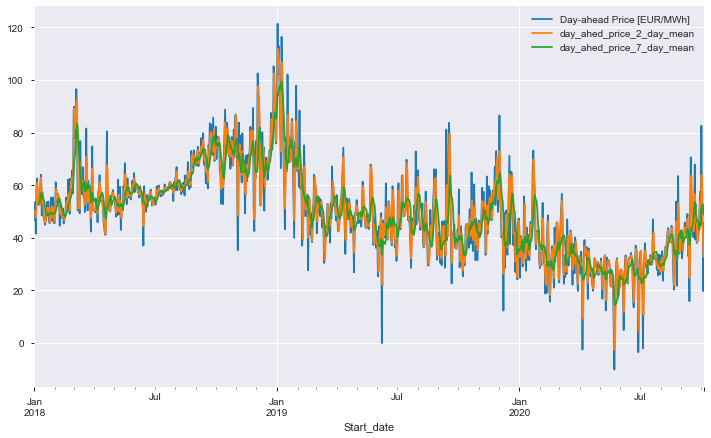

In [37]:
dap_df_new['day_ahed_price_7_day_mean'] = dap_df_new['Day-ahead Price [EUR/MWh]'].rolling(window=7).mean().round(2)
dap_df_new.plot(figsize=(12,7));

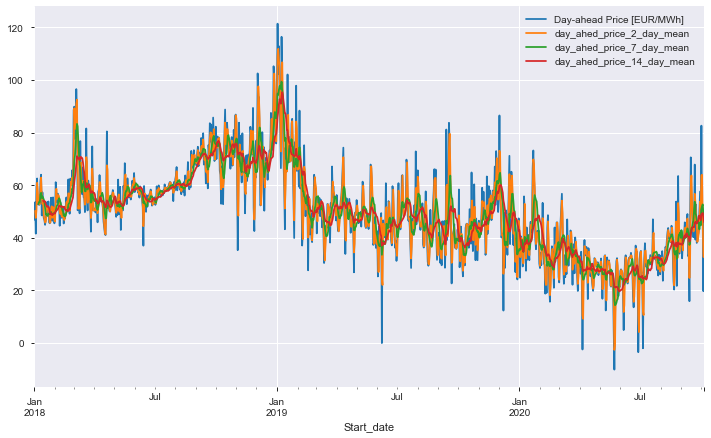

In [38]:
dap_df_new['day_ahed_price_14_day_mean'] = dap_df_new['Day-ahead Price [EUR/MWh]'].rolling(window=14).mean().round(2)
dap_df_new.plot(figsize=(12,7));

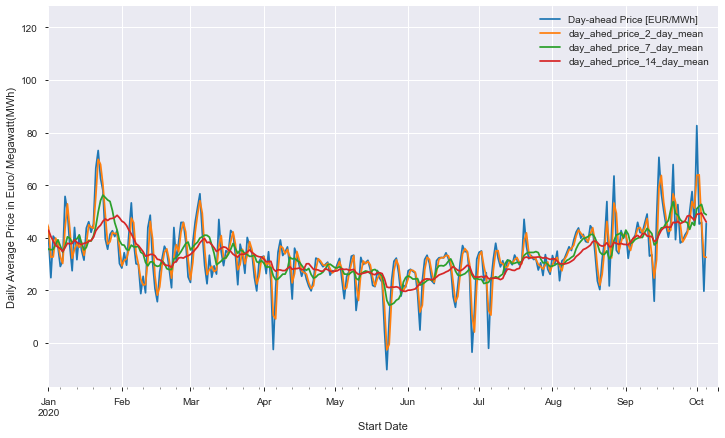

In [39]:
dap_df_new.plot(figsize=(12,7),xlim=['2020-01-01','2020-10-10'],
               xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)');

In [40]:
result = seasonal_decompose(dap_df_new['Day-ahead Price [EUR/MWh]'])

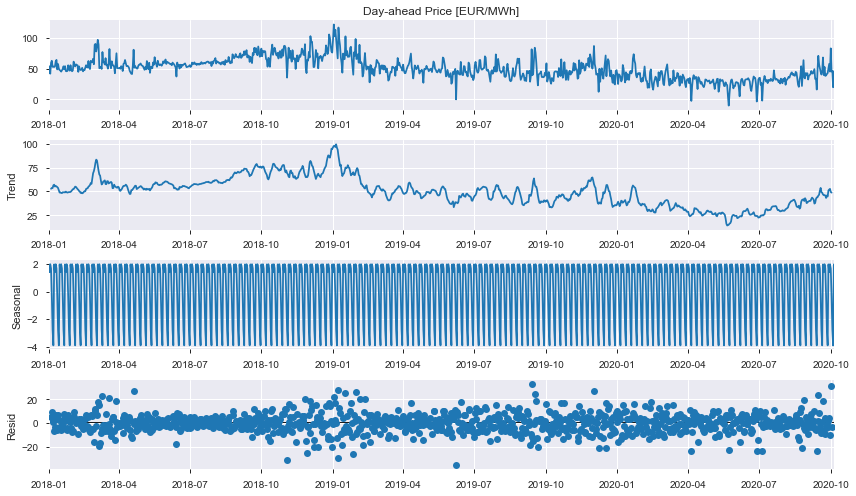

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] =12,7
result.plot();

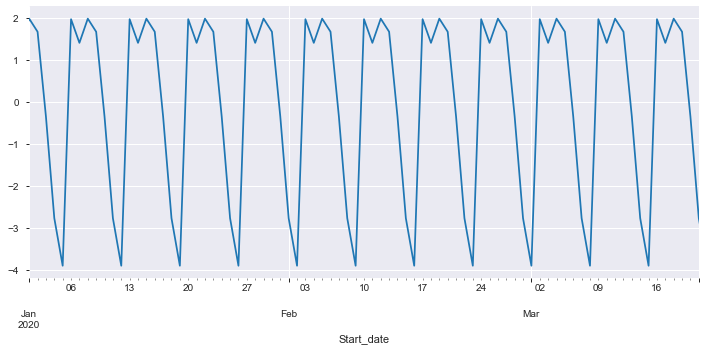

In [113]:
result.seasonal.plot(figsize = (12,5), xlim=['2020-01-01','2020-03-21']);

In [43]:
train_dap = pd.DataFrame(dap_df_new['Day-ahead Price [EUR/MWh]'].loc['2019-04-01':'2020-09-30'])
test_dap = pd.DataFrame(dap_df_new['Day-ahead Price [EUR/MWh]'].loc['2020-10-01':'2020-10-05'])

In [44]:
forecast_dap = pd.DataFrame(dap_df_new['Day-ahead Price [EUR/MWh]'].loc['2019-04-01':'2020-10-05'])

In [45]:
forecast_dap

,Day-ahead Price [EUR/MWh]
Start_date,
2019-04-01 00:00:00+00:00,56.27
2019-04-02 00:00:00+00:00,47.01
2019-04-03 00:00:00+00:00,42.60
2019-04-04 00:00:00+00:00,42.46
2019-04-05 00:00:00+00:00,46.84
...,...
2020-10-01 00:00:00+00:00,82.64
2020-10-02 00:00:00+00:00,45.27
2020-10-03 00:00:00+00:00,45.94


In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [47]:
fitted_model = ExponentialSmoothing(train_dap['Day-ahead Price [EUR/MWh]'], seasonal='add',
                                    seasonal_periods=7).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [48]:
test_prediction=fitted_model.forecast(5)

In [49]:
test_prediction

2020-10-01 00:00:00+00:00    47.795684
2020-10-02 00:00:00+00:00    46.559957
2020-10-03 00:00:00+00:00    42.711063
2020-10-04 00:00:00+00:00    41.271224
2020-10-05 00:00:00+00:00    47.869581
Freq: D, dtype: float64

<AxesSubplot:xlabel='Start_date'>

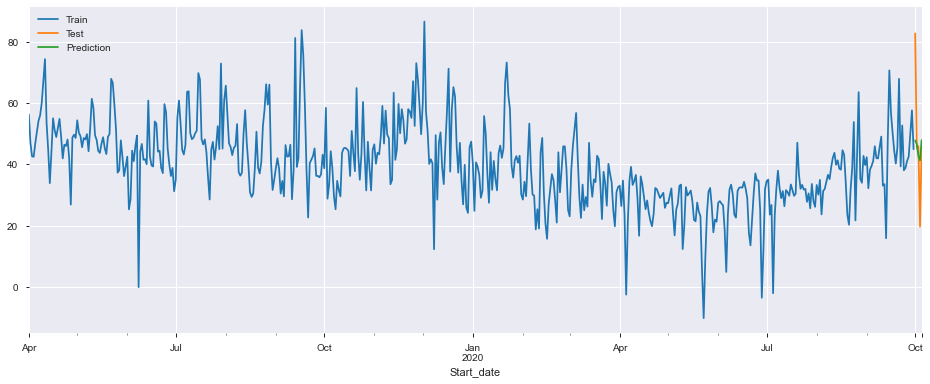

In [50]:
train_dap['Day-ahead Price [EUR/MWh]'].plot(legend = True, label = 'Train', figsize=(16,6))
test_dap['Day-ahead Price [EUR/MWh]'].plot(legend = True, label = 'Test')
test_prediction.plot(legend = True, label = 'Prediction')

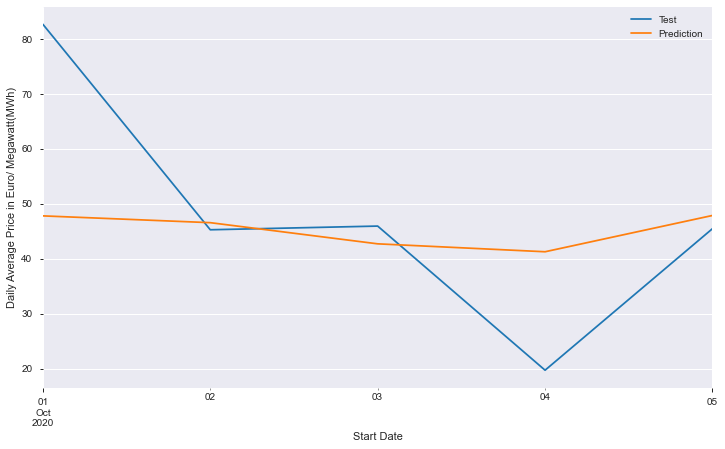

In [51]:
# train_dap['Day-ahead Price [EUR/MWh]'].plot(legend = True, label = 'Train', figsize=(16,6))
test_dap['Day-ahead Price [EUR/MWh]'].plot(legend = True, label = 'Test')
test_prediction.plot(legend = True, label = 'Prediction',xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)');

In [52]:
test_dap['Day-ahead Price [EUR/MWh]'].describe()

count     5.000000
mean     47.810000
std      22.455731
min      19.730000
25%      45.270000
50%      45.470000
75%      45.940000
max      82.640000
Name: Day-ahead Price [EUR/MWh], dtype: float64

In [53]:
# Holtwinters model 
print('Mean Absolute Error of Holtwinters model :',mean_absolute_error(test_dap['Day-ahead Price [EUR/MWh]'],test_prediction).round(2))
print('Mean Squared Error of Holtwinters model :',mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],test_prediction).round(2))
print('Root Mean Squared Error of Holtwinters model :',np.sqrt(mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],test_prediction)).round(2))

Mean Absolute Error of Holtwinters model : 12.66
Mean Squared Error of Holtwinters model : 339.2
Root Mean Squared Error of Holtwinters model : 18.42


In [54]:
mean_absolute_error(test_dap['Day-ahead Price [EUR/MWh]'],test_prediction)

12.660802800545408

In [55]:
mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],test_prediction)

339.19973481598674

In [56]:
np.sqrt(mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],test_prediction))
# The RMSE value of 15342.34 is prettey far from the test data standard deviation value of 36598.29 so we can say that our
# prediction is not good enough.

18.417375893866822

In [117]:
# mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
mape = np.mean(np.abs(test_prediction - test_dap['Day-ahead Price [EUR/MWh]'])/np.abs(test_dap['Day-ahead Price [EUR/MWh]']))
mape

0.33299877043989545

# Forecast with Holtwinters

In [57]:
forecast_model = ExponentialSmoothing(forecast_dap['Day-ahead Price [EUR/MWh]'], seasonal='add',
                                    seasonal_periods=7).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [58]:
forecast_prediction=forecast_model.forecast(5)

In [59]:
forecast_prediction

2020-10-06 00:00:00+00:00    46.468753
2020-10-07 00:00:00+00:00    47.578770
2020-10-08 00:00:00+00:00    45.671827
2020-10-09 00:00:00+00:00    43.983622
2020-10-10 00:00:00+00:00    40.193451
Freq: D, dtype: float64

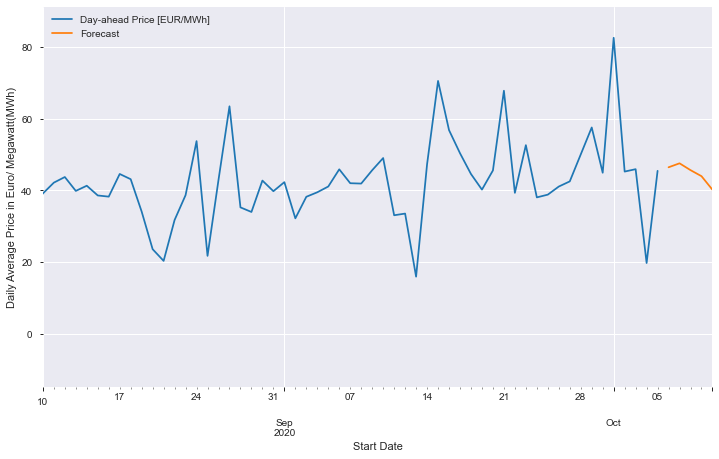

In [114]:
forecast_dap['Day-ahead Price [EUR/MWh]'].plot(legend = True)
forecast_prediction.plot(legend = True, label = 'Forecast', xlim=['2020-08-10','2020-10-10'],
                         xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)');

In [61]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

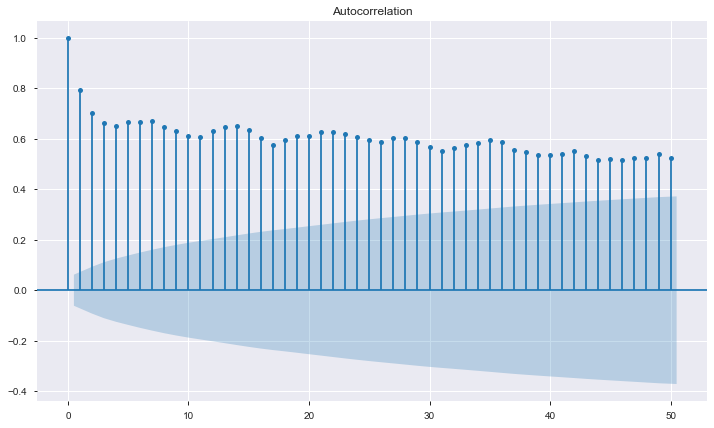

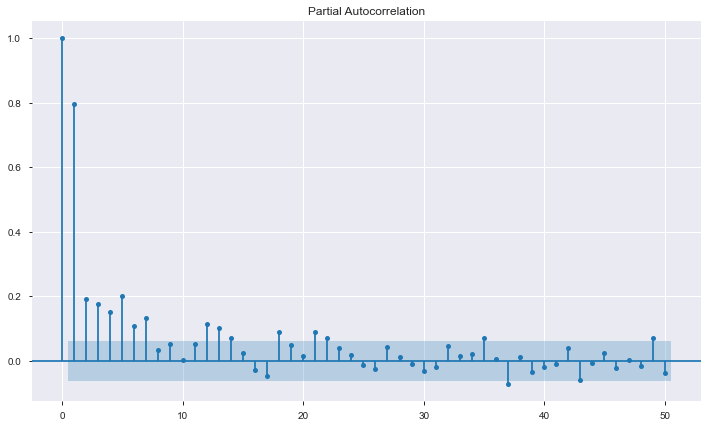

In [62]:
plot_acf(dap_df_new['Day-ahead Price [EUR/MWh]'],lags=50);
plot_pacf(dap_df_new['Day-ahead Price [EUR/MWh]'],lags=50);

In [63]:
from statsmodels.tsa.ar_model import AR, ARResults

In [64]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
train_dap_ar = train_dap['Day-ahead Price [EUR/MWh]']
train_dap_ar=pd.DataFrame(data=train_dap_ar)

In [66]:
test_dap_ar= test_dap['Day-ahead Price [EUR/MWh]']
test_dap_ar=pd.DataFrame(data=test_dap_ar)

In [67]:
pred_start_date= test_dap_ar.index[0]
pred_end_date = test_dap_ar.index[-1]

In [68]:
arima_1_model = AR(train_dap_ar['Day-ahead Price [EUR/MWh]'])

In [69]:
arima_1_model_fit = arima_1_model.fit(maxlag=1)

In [70]:
prediction_AR1= arima_1_model_fit.predict(start=pred_start_date, end =pred_end_date)

In [71]:
prediction_AR1

2020-10-01 00:00:00+00:00    43.093721
2020-10-02 00:00:00+00:00    41.905425
2020-10-03 00:00:00+00:00    41.140617
2020-10-04 00:00:00+00:00    40.648373
2020-10-05 00:00:00+00:00    40.331556
Freq: D, dtype: float64

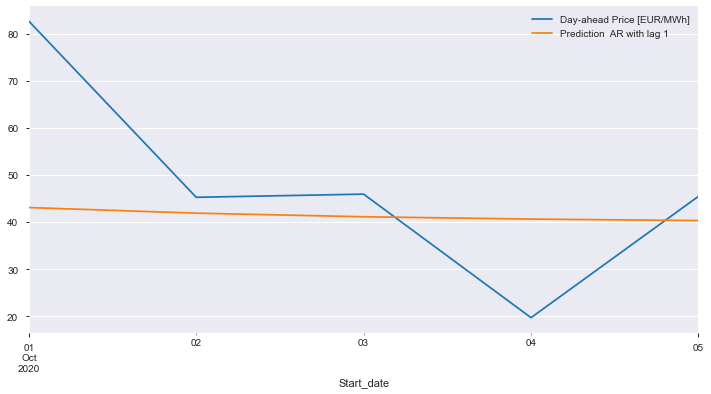

In [72]:
test_dap_ar.plot(figsize=(12,6), legend= True)
prediction_AR1.plot(legend =True, label = 'Prediction  AR with lag 1');

In [73]:
# AR model with lag 1
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR1))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR1))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR1)))

Mean Absolute Error of ARIMA model : 14.753410718321163
Mean Squared Error of ARIMA model : 412.4489044170349
Root Mean Squared Error of ARIMA model : 20.30883808633657


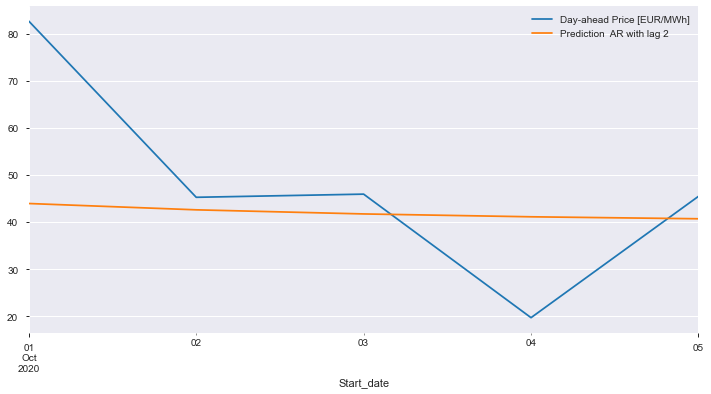

In [74]:
arima_2_model = AR(train_dap_ar['Day-ahead Price [EUR/MWh]'])
arima_2_model_fit = arima_2_model.fit(maxlag=2)
prediction_AR2= arima_2_model_fit.predict(start=pred_start_date, end =pred_end_date)
test_dap_ar.plot(figsize=(12,6), legend= True)
prediction_AR2.plot(legend =True, label = 'Prediction  AR with lag 2');

In [75]:
prediction_AR2

2020-10-01 00:00:00+00:00    43.951172
2020-10-02 00:00:00+00:00    42.610639
2020-10-03 00:00:00+00:00    41.739755
2020-10-04 00:00:00+00:00    41.133094
2020-10-05 00:00:00+00:00    40.714178
Freq: D, dtype: float64

In [76]:
# AR model with lag 2
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR2))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR2))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR2)))

Mean Absolute Error of ARIMA model : 14.341470020156425
Mean Squared Error of ARIMA model : 400.4499941785668
Root Mean Squared Error of ARIMA model : 20.011246692262


In [77]:
ar_final_model = AR(train_dap_ar['Day-ahead Price [EUR/MWh]'])
ar_final_model_fit = ar_final_model.fit(ic='aic')
ar_final_model_fit.params

const                            4.454854
L1.Day-ahead Price [EUR/MWh]     0.499430
L2.Day-ahead Price [EUR/MWh]    -0.051677
L3.Day-ahead Price [EUR/MWh]     0.097483
L4.Day-ahead Price [EUR/MWh]     0.006260
L5.Day-ahead Price [EUR/MWh]     0.104671
L6.Day-ahead Price [EUR/MWh]    -0.020993
L7.Day-ahead Price [EUR/MWh]     0.106238
L8.Day-ahead Price [EUR/MWh]    -0.008256
L9.Day-ahead Price [EUR/MWh]    -0.017714
L10.Day-ahead Price [EUR/MWh]   -0.015538
L11.Day-ahead Price [EUR/MWh]   -0.087401
L12.Day-ahead Price [EUR/MWh]    0.096358
L13.Day-ahead Price [EUR/MWh]    0.050601
L14.Day-ahead Price [EUR/MWh]    0.087510
L15.Day-ahead Price [EUR/MWh]    0.052098
L16.Day-ahead Price [EUR/MWh]   -0.030701
L17.Day-ahead Price [EUR/MWh]   -0.106880
L18.Day-ahead Price [EUR/MWh]    0.124395
dtype: float64

In [78]:
prediction_AR18= ar_final_model_fit.predict(start=pred_start_date, end =pred_end_date)

In [79]:
# ar_final_model_fit.k_ar

In [80]:
# prediction_AR18

<AxesSubplot:xlabel='Start_date'>

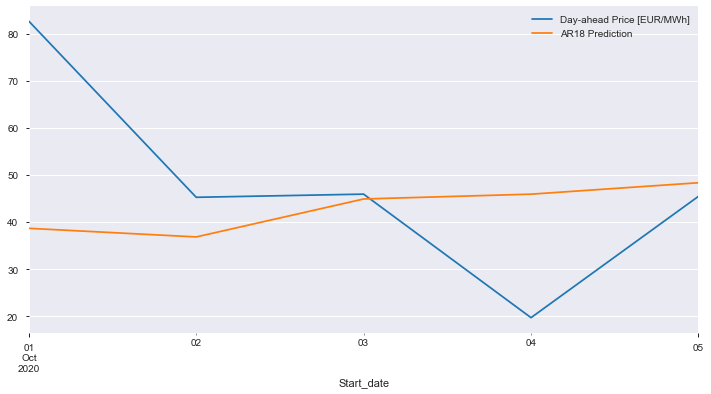

In [81]:
test_dap_ar.plot(figsize=(12,6), legend= True)
prediction_AR18.plot(legend =True, label = 'AR18 Prediction')

In [112]:
# AR model with lag 18
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR18))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR18))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_AR18)))

Mean Absolute Error of ARIMA model : 16.496201710992064
Mean Squared Error of ARIMA model : 539.7023958705596
Root Mean Squared Error of ARIMA model : 23.23149577342276


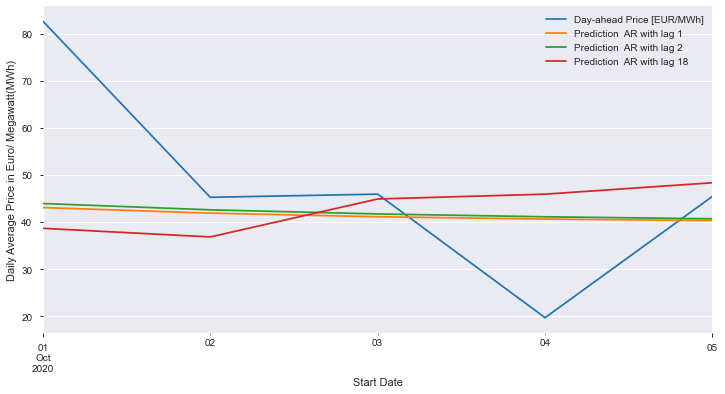

In [83]:
test_dap_ar.plot(figsize=(12,6), legend= True, label = 'Test Data',xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)')
prediction_AR1.plot(legend =True, label = 'Prediction  AR with lag 1')
prediction_AR2.plot(legend =True, label = 'Prediction  AR with lag 2')
prediction_AR18.plot(legend =True, label = 'Prediction  AR with lag 18');

In [84]:
prediction_AR18

2020-10-01 00:00:00+00:00    38.688135
2020-10-02 00:00:00+00:00    36.859509
2020-10-03 00:00:00+00:00    44.911559
2020-10-04 00:00:00+00:00    45.933392
2020-10-05 00:00:00+00:00    48.356819
Freq: D, dtype: float64

In [85]:
# Stationarity Test.

In [86]:
from statsmodels.tsa.stattools import adfuller

In [87]:
adfuller(train_dap['Day-ahead Price [EUR/MWh]'])

(-2.1868887125804077,
 0.2110384654630103,
 18,
 530,
 {'1%': -3.4427485933555886,
  '5%': -2.8670087381529723,
  '10%': -2.569682641509434},
 3900.50492923487)

In [88]:
first_diff = train_dap['Day-ahead Price [EUR/MWh]'] - train_dap['Day-ahead Price [EUR/MWh]'].shift(1)
first_diff = first_diff.dropna(inplace = False)

In [89]:
# train_dap['#Passengers_diff'] = train['#Passengers'] - train['#Passengers'].shift(1)
# train['#Passengers_diff'].dropna().plot()

In [90]:
adfuller(first_diff)

(-8.682421983694612,
 4.250638131042123e-14,
 19,
 528,
 {'1%': -3.4427957890025533,
  '5%': -2.867029512430173,
  '10%': -2.5696937122646926},
 3897.081648039797)

In [91]:
adfuller(train_dap['Day-ahead Price [EUR/MWh]'].diff().dropna())

(-8.682421983694612,
 4.250638131042123e-14,
 19,
 528,
 {'1%': -3.4427957890025533,
  '5%': -2.867029512430173,
  '10%': -2.5696937122646926},
 3897.081648039797)

In [92]:
# resDiff = sm.tsa.arma_order_select_ic(train_dap['Day-ahead Price [EUR/MWh]'], max_ar=7, max_ma=7, ic='aic',)
# print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [93]:
model = pm.auto_arima(train_dap['Day-ahead Price [EUR/MWh]'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      ic='aic',              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5662.918, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4202.248, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5098.099, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4179.076, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4141.526, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4056.869, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4059.376, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4058.717, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4056.571, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4057.743, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4058.518, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4130.556, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4

In [94]:
arima_model = ARIMA(train_dap['Day-ahead Price [EUR/MWh]'], order=(1,0,3))

In [95]:
arima_model_fit = arima_model.fit()

In [96]:
prediction_arima = arima_model_fit.predict(start=pred_start_date, end =pred_end_date)

In [97]:
prediction_arima

2020-10-01 00:00:00+00:00    43.352023
2020-10-02 00:00:00+00:00    44.285842
2020-10-03 00:00:00+00:00    44.624730
2020-10-04 00:00:00+00:00    44.603137
2020-10-05 00:00:00+00:00    44.581726
Freq: D, dtype: float64

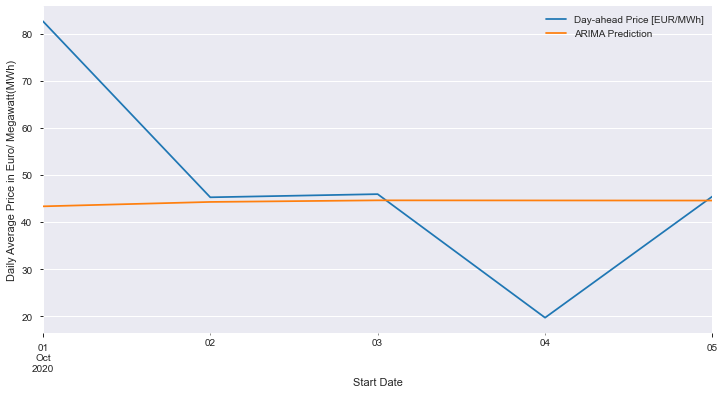

In [98]:
test_dap_ar.plot(figsize=(12,6), legend= True, label= 'Test data')
prediction_arima.plot(legend =True, label = 'ARIMA Prediction', xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)');

In [99]:
# ARIMA model with order of (1,0,3)
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_arima))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_arima))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_arima)))

Mean Absolute Error of ARIMA model : 13.469763217721612
Mean Squared Error of ARIMA model : 433.1411195154693
Root Mean Squared Error of ARIMA model : 20.812042656007346


In [ ]:
# p = d = q = range(0, 4)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(dap_df_new['Day-ahead Price [EUR/MWh]'],order=param,seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue


In [272]:
auto_model = auto_arima(train_dap_ar,start_p=0,start_q=0, max_p=9, max_q=5, start_P=0, start_Q=0,m=7, seasonal= True)

In [273]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  549
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -2013.426
Date:                           Sun, 29 Nov 2020   AIC                           4040.851
Time:                                   04:13:55   BIC                           4070.995
Sample:                                        0   HQIC                          4052.633
                                           - 549                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0020      0.004     -0.474      0.635      -0.010       0.006
ar.L1          0.4239      0.038     11.169      0.000       0.350       0.498
ma.L1         -0.9659      0.014    -69.395      0.000      -0.993      -0.939
ar.S.L7        0.8283      0.154      5.371      0.000       0.526       1.131
ar.S.L14       0.0179      0.058      0.308      0.758      -0.096       0.132
ma.S.L7       -0.7338      0.159     -4.609      0.000      -1.046      -0.422
sigma2        94.8819      4.569     20.765      0.000      85.926     103.837
===================================================================================
Ljung-Box (Q):                       58.02   Jarque-Bera (JB):               119.89
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.01
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [101]:
sarima_model = sm.tsa.statespace.SARIMAX(dap_df_new['Day-ahead Price [EUR/MWh]'],
                                order=(1, 1, 1),
                                seasonal_order=(2, 0, 1, 7),)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3949      0.027     14.901      0.000       0.343       0.447
ma.L1         -0.9182      0.012    -74.211      0.000      -0.942      -0.894
ar.S.L7        0.9918      0.034     28.926      0.000       0.925       1.059
ar.S.L14      -0.0006      0.031     -0.020      0.984      -0.061       0.060
ma.S.L7       -0.9639      0.021    -45.827      0.000      -1.005      -0.923
sigma2        89.0947      2.769     32.174      0.000      83.667      94.522


In [102]:
prediction_sarima = sarima_model_fit.predict(start=pred_start_date, end =pred_end_date)

In [103]:
# prediction_sarima

<AxesSubplot:xlabel='Start Date', ylabel='Daily Average Price in Euro/ Megawatt(MWh)'>

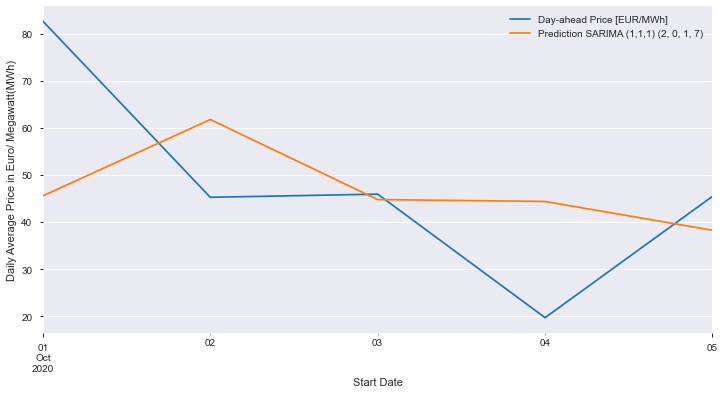

In [104]:
test_dap_ar.plot(figsize=(12,6), legend= True)
prediction_sarima.plot(legend = True ,label = 'Prediction SARIMA (1,1,1) (2, 0, 1, 7)',xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)')

In [105]:
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_sarima))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_sarima))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dap['Day-ahead Price [EUR/MWh]'],prediction_sarima)))

Mean Absolute Error of ARIMA model : 17.312873822403457
Mean Squared Error of ARIMA model : 461.3912985316621
Root Mean Squared Error of ARIMA model : 21.4800209155313


In [106]:
# results.plot_diagnostics(figsize=(16, 6))
# plt.show()

In [108]:
# pred = results.get_prediction(start=pred_start_date, end= pred_end_date, dynamic=False)
# pred_ci = pred.conf_int()
# ax = train_dap['2014':].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
# ax.set_xlabel('Date')
# ax.set_ylabel('DAY-Ahead-Price')
# plt.legend()
# plt.show()


In [110]:
# prediction_arima = results.predict(start=pred_start_date, end =pred_end_date)

<AxesSubplot:xlabel='Start_date'>

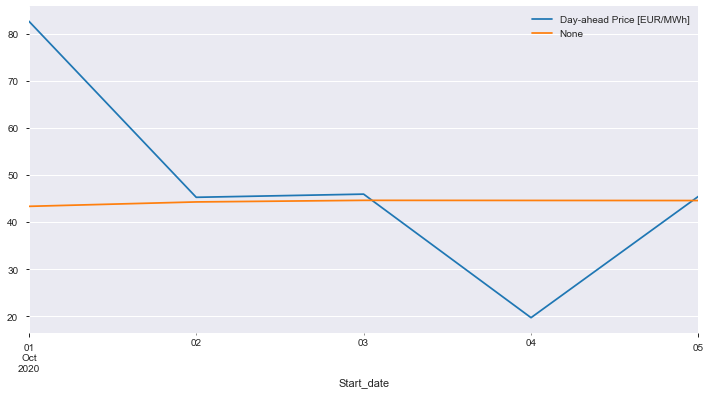

In [111]:
test_dap_ar.plot(figsize=(12,6), legend= True)
prediction_arima.plot(legend =True)